![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 12 - Non-parametric Regression </center>
### <center> Kernel Regression </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/12_NonparametricRegression/MainKernelRegression.ipynb)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

### Generate some data:
$$\mathcal{D}_{\text{train}}=\left\{ \left(x_{i},y_{i}\right)\right\} _{i=1}^{N}$$

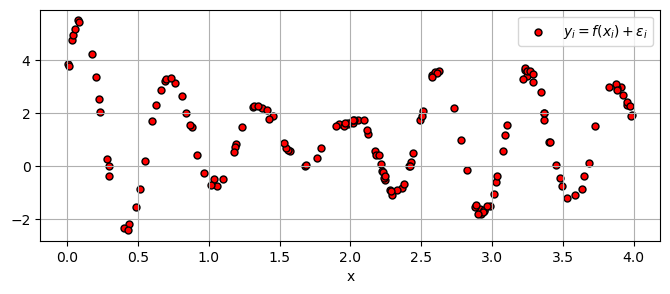

In [2]:
N   = 150
vX  = 4 * np.random.rand(N)
vY  = 5 * np.exp(-vX) * np.sin(10*vX + .5) * (1 + 10 * (vX > 2) * (vX - 2)) + 1
vY += np.random.randn(N) / 10

plt.figure (figsize=(8, 3))
plt.scatter(vX, vY, s=25, c='r', edgecolor='k', label='$y_i = f(x_i) + \epsilon_i$')
plt.xlabel ('x')
plt.legend ()
plt.grid   ()
plt.show   ()

### Define some kernels:
-- Uniform: $k\left(u\right)=\begin{cases}
1 & \left|u\right|\leq\frac{1}{2}\\
0 & \text{else}
\end{cases}$

-- Triangular: $k\left(u\right)=\begin{cases}
1-\left|u\right| & \left|u\right|\leq1\\
0 & \text{else}
\end{cases}$

-- Gaussian: $k\left(u\right)=e^{-\frac{1}{2}u^{2}}$

-- Cosine: $k\left(u\right)=\begin{cases}
1+\cos\left(\pi u\right) & \left|u\right|\leq1\\
0 & \text{else}
\end{cases}$

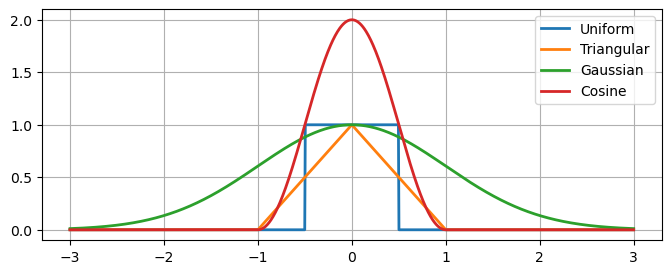

In [3]:
def Uniform   (vU): return 1 * (np.abs(vU) < 1/2)
def Triangular(vU): return (np.abs(vU) < 1) * (1 - np.abs(vU))
def Gaussian  (vU): return np.exp(-vU**2 / 2)
def Cosine    (vU): return (np.abs(vU) < 1) * (1 + np.cos(np.pi * vU))

xx = np.linspace(-3, 3, 1000, endpoint=True)
plt.figure(figsize=(8, 3))
plt.plot  (xx, Uniform(xx),    lw=2, label='Uniform'   )
plt.plot  (xx, Triangular(xx), lw=2, label='Triangular')
plt.plot  (xx, Gaussian(xx),   lw=2, label='Gaussian'  )
plt.plot  (xx, Cosine(xx),     lw=2, label='Cosine'    )
plt.legend()
plt.grid  ()
plt.show  ()

### Plot kernel regression:
$$\boxed{\hat{f}\left(x\right)=\frac{\sum_{i=1}^{N}w_{x}\left(x_{i}\right)y_{i}}{\sum_{i=1}^{N}w_{x}\left(x_{i}\right)}}$$
where $$w_{x}\left(x_{i}\right)=k\left(\frac{x-x_{i}}{h}\right)$$

In [4]:
#-- Removing warning:
np.seterr(divide='ignore', invalid='ignore')

xx = np.linspace(-0.2, 4.5, 1000, endpoint=True)

def PlotKernelRegression(Kernel, h):
    mW    = Kernel((xx[:,None] - vX[None,:]) / h)
    vHatY = (mW @ vY) / np.sum(mW, 1)
    
    plt.figure (figsize=(14, 4))
    plt.plot   (xx, vHatY, 'b', lw=2, label='$\hat{f}(x)$')
    plt.scatter(vX, vY, s=50, c='r', edgecolor='k', label='$y_i = f(x_i) + \epsilon_i$')
    plt.title  (f'h = {h}')
    plt.xlabel ('x')
    plt.grid   ()
    plt.legend (loc='lower right')

In [5]:
from ipywidgets import interact, FloatSlider, Layout, Dropdown

hSlider        = FloatSlider(min=0.005, max=.3, step=0.005, value=0.01, layout=Layout(width='80%'))
kernelDropdown = Dropdown(
        options    =[('Uniform', Uniform), ('Triangular', Triangular), ('Gaussian', Gaussian), ('Cosine', Cosine)],
        value      = Gaussian,
        description='Kernel:',
)
interact(PlotKernelRegression, Kernel=kernelDropdown, h=hSlider)
plt.show()

interactive(children=(Dropdown(description='Kernel:', index=2, options=(('Uniform', <function Uniform at 0x000…

### Extra: Real data example:

In [6]:
import sklearn.datasets

dData = sklearn.datasets.load_boston()

C:\Users\oryai\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [7]:
mX = dData.data
vY = dData.target

mX -= mX.mean(0)
mX /= mX.std(0)

mX.shape, vY.shape

((506, 13), (506,))

$$\boxed{\hat{f}\left(x\right)=\frac{\sum_{i=1}^{N}w_{x}\left(x_{i}\right)y_{i}}{\sum_{i=1}^{N}w_{x}\left(x_{i}\right)}}$$
where $$w_{x}\left(x_{i}\right)=k\left(\frac{x-x_{i}}{h}\right)$$

#### Leave-one-out (vectorized) kernel regression:
1. **set** $\boldsymbol{D}_{x}\in\mathbb{R}^{N\times N}$ such that $$\boldsymbol{D}_{x}\left[i,j\right]=\left\Vert \boldsymbol{x}_{i}-\boldsymbol{x}_{j}\right\Vert _{2}$$
2. **set** $\boldsymbol{W}\in\mathbb{R}^{N\times N}$ such that $$\boldsymbol{W}\left[i,j\right]=k\left(\frac{1}{h}\boldsymbol{D}_{x}\left[i,j\right]\right)$$
3. To estimate $\boldsymbol{x}_{i}$ without using $\boldsymbol{x}_{i}$
we set $$\boldsymbol{W}\left[i,i\right]=0$$
4. Apply kernel regression: $$\hat{\boldsymbol{y}}=\left(\boldsymbol{W}\boldsymbol{y}\right)\oslash\left(\boldsymbol{W}\boldsymbol{1}\right)$$

In [8]:
from sklearn.metrics        import r2_score
from scipy.spatial.distance import cdist

N                     = len(vY)
k                     = Gaussian      #-- kernel
h                     = .5            #-- bandwidth
mD                    = cdist(mX, mX) #-- pairwise distances
mW                    = k(mD / h)     #-- Weights
mW[range(N),range(N)] = 0             #-- leave-one-out cross validation

vHatY = (mW @ vY) / np.sum(mW, 1)     #-- kernel regression
r2_score(vY, vHatY)

0.8220263327938513